In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats
import seaborn as sns
from nltk.util import bigrams
%matplotlib inline
sns.set()

In [2]:
# Global plot parameters
FIGSIZE = (13,8)
TITLE_FONT = {'size': 18}
BAR_PLOT_FONT = {'fontsize': 14}
LEGEND_FONT = {'fontsize': 14}
LABEL_FONT = {'size'   : 15}

In [3]:
# Price tier bins
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

# Tick labels for price tiers
bin_labels = ['{} - {}'.format(b1, b2) for b1, b2 in bigrams(price_bins)]

In [4]:
def load_reshape_samples(file_name):
    with open(file_name) as f:
        samples = json.load(f)
        return {k: [sample[k] for sample in samples]
                for k in samples[0].keys()}

In [5]:
# Load the data to plot
incent           = load_reshape_samples('incent_results.json')
incent2          = load_reshape_samples('incent_results_2.json')
non_incent       = load_reshape_samples('non_incent_results.json')
non_incent2      = load_reshape_samples('non_incent_results_2.json')
whole_dataset    = load_reshape_samples('whole_dataset_results.json')
elec_incent      = load_reshape_samples('elec_incent_results.json')
elec_non_incent  = load_reshape_samples('elec_non_incent_results.json')
elec_incent3     = load_reshape_samples('elec_incent_results3.json')
elec_non_incent3 = load_reshape_samples('elec_non_incent_results3.json')

In [6]:
# Functions to do groupby on dictionaries
def reshape_grouped_by(data, by, values):
    return {v: [group['_c1']
                for sample in data
                    for group in sample
                        if group[by] == v]
            for v in values}

categories = [c['main_category'] for c in incent['avg_length_by_category'][0]]
def reshape_grouped_by_category(data):
    return {k: reshape_grouped_by(v, 'main_category', categories)
            for k, v in data.items()
               if k.endswith('by_category')}

price_tiers = [c['price_tier'] for c in incent['num_reviews_by_price_tier'][0]]
def reshape_grouped_by_price_tier(data):
    return {k: reshape_grouped_by(v, 'price_tier', price_tiers)
            for k, v in data.items()
                if k.endswith('by_price_tier')}

def reshape_grouped_by_overall(data):
    return {k: reshape_grouped_by(v, 'overall', range(1, 6))
            for k, v in data.items()
                if (k != ('sentiment_distribution_by_rating')) and (k.endswith('by_overall') or k.endswith('by_rating'))}

In [7]:
# Data for plots by category
incent_by_category        = reshape_grouped_by_category(incent)
non_incent_by_category    = reshape_grouped_by_category(non_incent)
whole_dataset_by_category = reshape_grouped_by_category(whole_dataset)
incent2_by_category       = reshape_grouped_by_category(incent2)
non_incent2_by_category   = reshape_grouped_by_category(non_incent2)

In [8]:
# Data for plots by price tier
incent_by_price_tier          = reshape_grouped_by_price_tier(incent)
non_incent_by_price_tier      = reshape_grouped_by_price_tier(non_incent)
whole_dataset_by_price_tier   = reshape_grouped_by_price_tier(whole_dataset)
elec_incent_by_price_tier     = reshape_grouped_by_price_tier(elec_incent)
elec_non_incent_by_price_tier = reshape_grouped_by_price_tier(elec_non_incent)

In [9]:
# Data for plots by overall
incent_by_overall          = reshape_grouped_by_overall(incent)
non_incent_by_overall      = reshape_grouped_by_overall(non_incent)
whole_dataset_by_overall   = reshape_grouped_by_overall(whole_dataset)
elec_incent_by_overall     = reshape_grouped_by_overall(elec_incent)
elec_non_incent_by_overall = reshape_grouped_by_overall(elec_non_incent)
incent2_by_overall         = reshape_grouped_by_overall(incent2)
non_incent2_by_overall     = reshape_grouped_by_overall(non_incent2)

In [10]:
def confidence_interval(estimates, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def dict_barplot(data, errs, ax=None):
    if ax is None:
        ax = plt.subplot()
    data.plot(kind='bar', ax=ax, yerr=errs, **BAR_PLOT_FONT)
    plt.legend(**LEGEND_FONT)

# Incentivized

In [11]:
def plot_with_conf_interval(data_incent, data_non_incent, confidence=0.95,
                            ax=None, sort_value=False, normalize=False):
    # Compute the mean (and its confidence interval) of incentivized reviews
    conf_incent = {k: confidence_interval(v, confidence) for k, v in data_incent.items()}
    means_incent = {k: v[0] for k, v in conf_incent.items()}
    errs_incent = {k: v[2] - v[1] for k, v in conf_incent.items()}
    
    # Compute the mean (and its confidence interval) of non incentivized reviews
    conf_non_incent = {k: confidence_interval(v, confidence) for k, v in data_non_incent.items()}
    means_non_incent = {k: v[0] for k, v in conf_non_incent.items()}
    errs_non_incent = {k: v[2] - v[1] for k, v in conf_non_incent.items()}
    
    # Create dataframes for the plot function
    df_value = pd.DataFrame({'Incentivized': means_incent, 'Non incentivized': means_non_incent})
    df_error = pd.DataFrame({'Incentivized': errs_incent,  'Non incentivized': errs_non_incent})
    
    if normalize:
        s = df_value.sum(axis=0)
        df_value, df_error = df_value/s, df_error/s
    
    if sort_value:
        df_value.sort_values(by='Incentivized', inplace=True)
        df_error = df_error.loc[df_value.index.values]
    
    dict_barplot(df_value, df_error, ax=ax) 

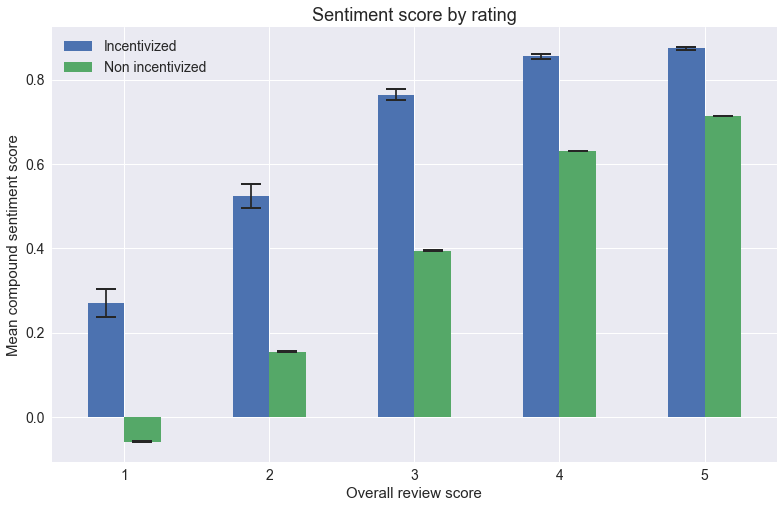

In [12]:
title = 'avg_compound_by_rating'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_overall[title],
                        non_incent_by_overall[title],
                        ax=ax)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Mean compound sentiment score', LABEL_FONT)
plt.title('Sentiment score by rating', TITLE_FONT)

fig.savefig(title + '.png', bbox_inches='tight')
# fig.savefig('sentiment_by_rating.png', bbox_inches='tight')

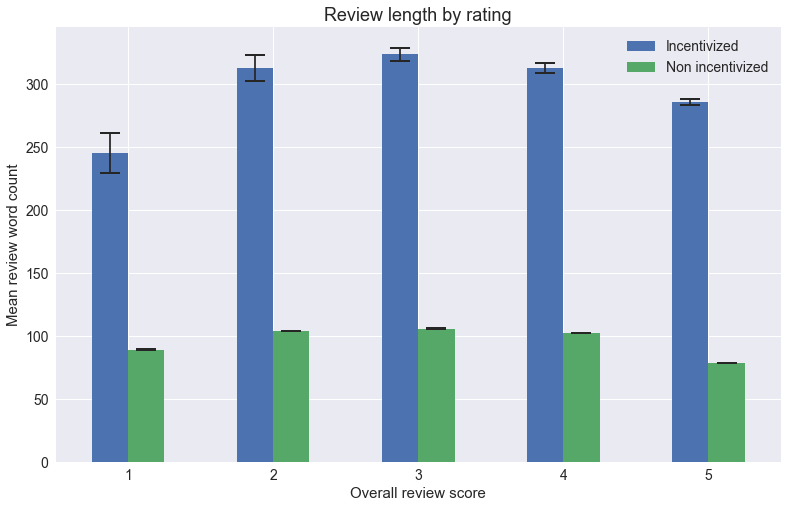

In [13]:
title = 'avg_length_by_overall'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_overall[title],
                        non_incent_by_overall[title],
                        ax=ax)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Mean review word count', LABEL_FONT)
plt.title('Review length by rating', TITLE_FONT)

fig.savefig(title + '.png', bbox_inches='tight')
# fig.savefig('wordcount_by_rating.png', bbox_inches='tight')

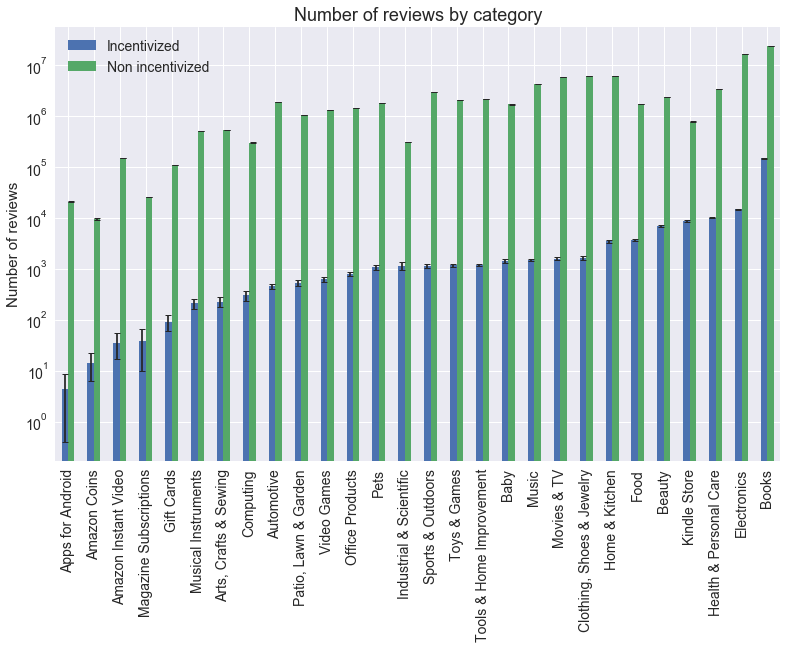

In [14]:
title = 'num_reviews_by_category'

mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_category[title],
                        non_incent_by_category[title],
                        ax=ax, sort_value=True)

ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Number of reviews', LABEL_FONT)
plt.title('Number of reviews by category', TITLE_FONT)

fig.savefig(title + '.png', bbox_inches='tight')

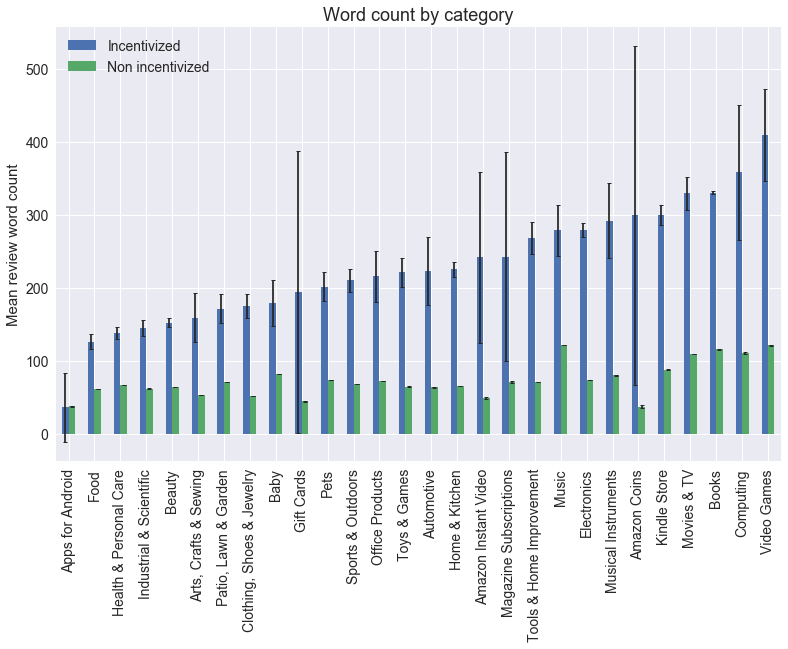

In [15]:
title = 'avg_length_by_category'

mpl.rcParams['errorbar.capsize'] = 2
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent_by_category[title],
                        non_incent_by_category[title],
                        ax=ax, sort_value=True)

ax.set_xlabel('')
ax.set_ylabel('Mean review word count', LABEL_FONT)
plt.title('Word count by category', TITLE_FONT)

fig.savefig(title + '.png', bbox_inches='tight')

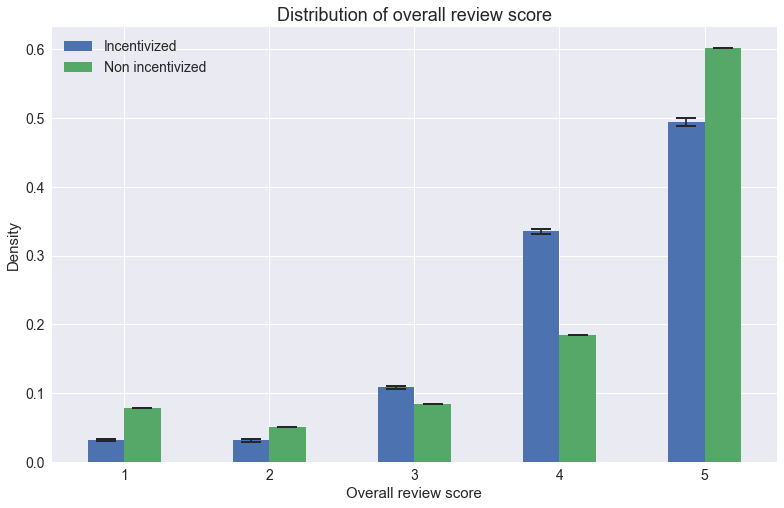

In [16]:
title = 'count_by_overall'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(incent2_by_overall[title],
                        non_incent2_by_overall[title],
                        ax=ax, normalize=True)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Density', LABEL_FONT)
plt.title('Distribution of overall review score', TITLE_FONT)

fig.savefig(title + '.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


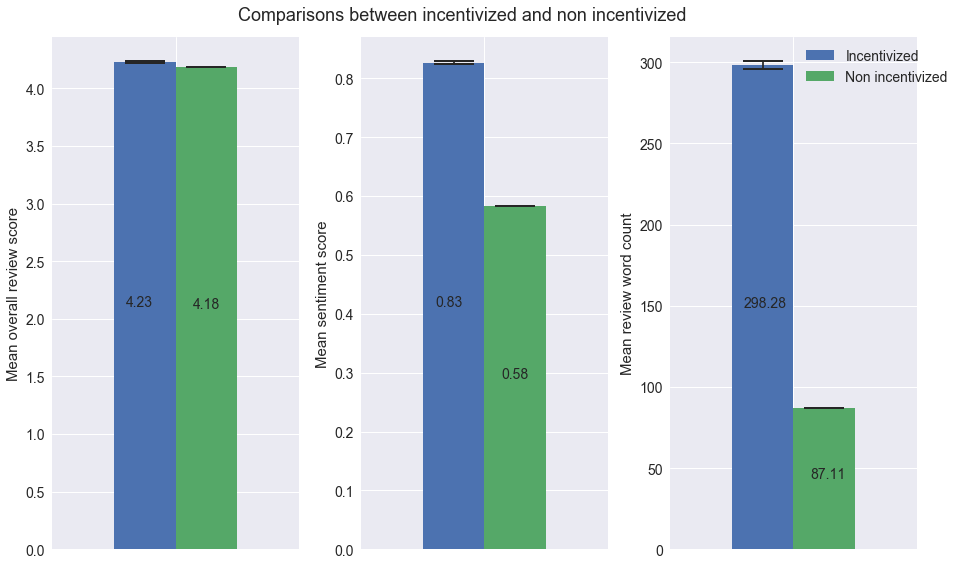

In [17]:
titles = ['avg_overall', 'avg_compound', 'avg_word_count']

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2

fig, axs = plt.subplots(1,3,figsize=FIGSIZE)
for id, title in enumerate(titles):
    ax = axs[id]
    
    # Obtain the data and plot it
    data_incent = [group['_c0'] for sample in incent2[title] for group in sample]
    data_non_incent = [group['_c0'] for sample in non_incent2[title] for group in sample]
    plot_with_conf_interval({title: data_incent}, {title: data_non_incent}, ax=ax)
    ax.set_xticklabels('')
    
    # Add text to the plot
    incent_mean, non_incent_mean = np.mean(data_incent), np.mean(data_non_incent)
    ax.text(x=-0.2, y=incent_mean/2, s=str(np.round(incent_mean,2)), fontsize=14)
    ax.text(x= 0.07, y=non_incent_mean/2, s=str(np.round(non_incent_mean,2)), fontsize=14)
    
    if id!=2:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0.5, 1), **LEGEND_FONT)

axs[0].set_ylabel('Mean overall review score', LABEL_FONT)
axs[1].set_ylabel('Mean sentiment score', LABEL_FONT)
axs[2].set_ylabel('Mean review word count', LABEL_FONT)
plt.suptitle('Comparisons between incentivized and non incentivized', **TITLE_FONT)
plt.tight_layout(rect=(0,0,1,0.95))

fig.savefig('comp_incent.png', bbox_inches='tight')

# Whole dataset

In [18]:
def plot_with_conf_interval_single(data, confidence=0.95, ax=None, sort_value=False):
    # Compute the mean and its confidence interval
    conf = {k: confidence_interval(v, confidence) for k, v in data.items()}
    means = {k: v[0] for k, v in conf.items()}
    errs = {k: v[2] - v[1] for k, v in conf.items()}
    
    # Create dataframes for the plot function
    df_value = pd.DataFrame({'Whole dataset': means})
    df_error = pd.DataFrame({'Whole dataset': errs})
    
    if sort_value:
        df_value.sort_values(by='Whole dataset', inplace=True)
        df_error = df_error.loc[df_value.index.values]
    
    dict_barplot(df_value, df_error, ax=ax) 

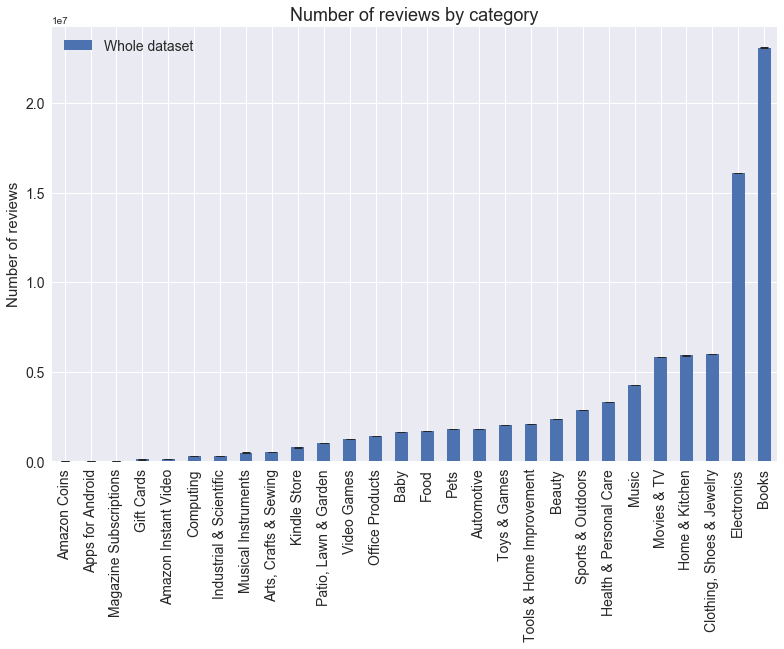

In [19]:
title = 'num_reviews_by_category'

mpl.rcParams['errorbar.capsize'] = 4
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_category[title],
                               ax=ax, sort_value=True)

ax.set_xlabel('')
ax.set_ylabel('Number of reviews', LABEL_FONT)
plt.title('Number of reviews by category', TITLE_FONT)

fig.savefig('whole_' + title + '.png', bbox_inches='tight')

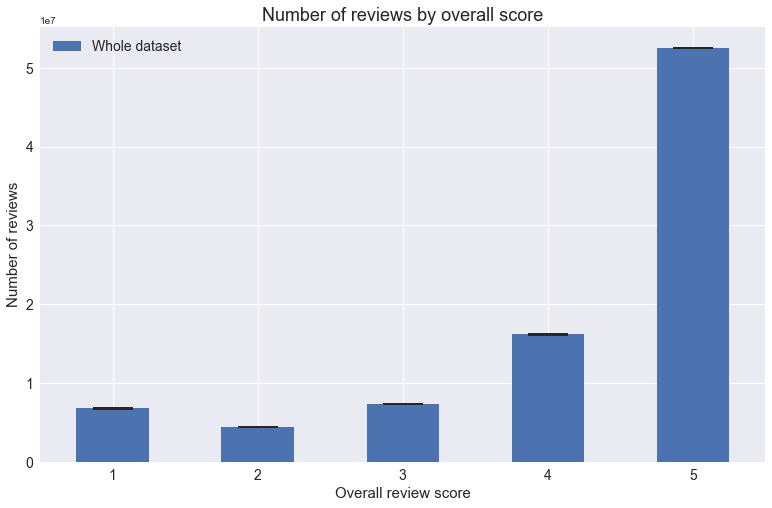

In [20]:
title = 'num_reviews_by_overall'

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Number of reviews', LABEL_FONT)
plt.title('Number of reviews by overall score', TITLE_FONT)

fig.savefig('whole_' + title + '.png', bbox_inches='tight')

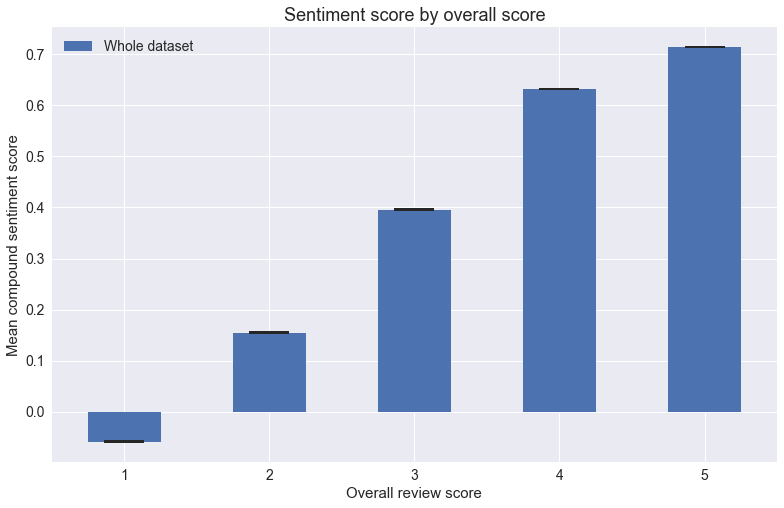

In [21]:
title = 'avg_compound_by_overall'

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Mean compound sentiment score', LABEL_FONT)
plt.title('Sentiment score by overall score', TITLE_FONT)

fig.savefig('whole_' + title + '.png', bbox_inches='tight')

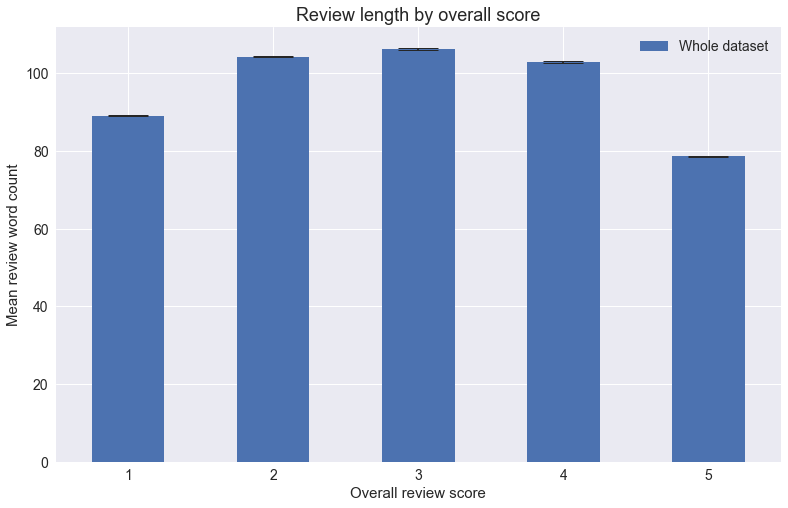

In [22]:
title = 'avg_length_by_overall'

mpl.rcParams['errorbar.capsize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_overall[title], ax=ax)

ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Mean review word count', LABEL_FONT)
plt.xticks(rotation=0)
plt.title('Review length by overall score', TITLE_FONT)
fig.savefig('whole_' + title + '.png', bbox_inches='tight')

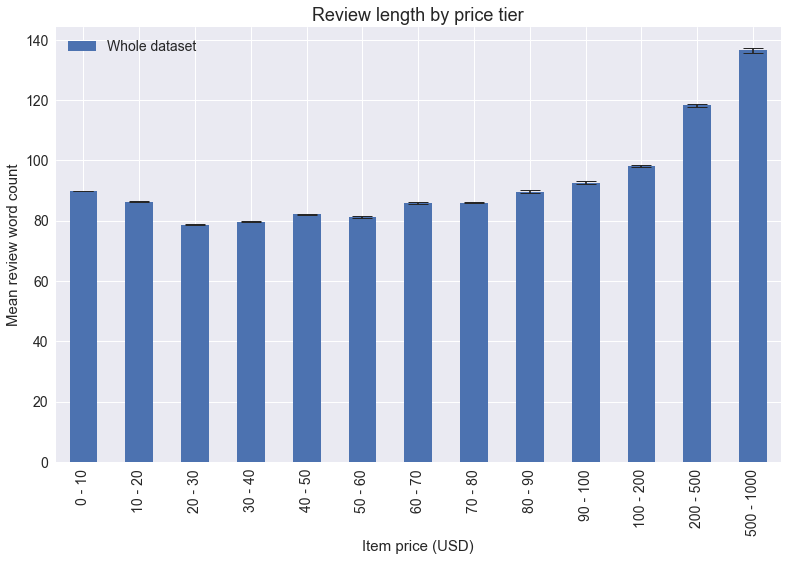

In [23]:
title = 'avg_length_by_price_tier'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_by_price_tier[title], ax=ax)

ax.set_xticklabels(bin_labels)
ax.set_xlabel('Item price (USD)', LABEL_FONT)
ax.set_ylabel('Mean review word count', LABEL_FONT)
plt.title('Review length by price tier', TITLE_FONT)

fig.savefig('whole_' + title + '.png', bbox_inches='tight')

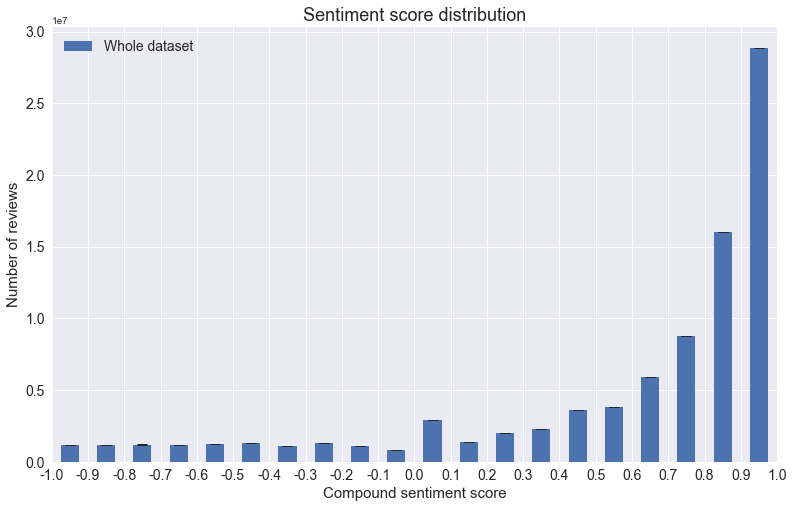

In [24]:
title = 'compound_score_hist'

whole_compound_data_by_bin = np.asarray([data for bins, data in whole_dataset['compound_histogram']]).T
whole_dataset_compound_hist = dict(enumerate(whole_compound_data_by_bin))

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval_single(whole_dataset_compound_hist, ax=ax)

bins = whole_dataset['compound_histogram'][0][0]
ax.set_xticklabels(list(map(lambda x: np.round(x, 1), bins)), rotation=0)
ax.set_xticks(np.linspace(-0.5,19.5,21))

ax.set_xlabel('Compound sentiment score', LABEL_FONT)
ax.set_ylabel('Number of reviews', LABEL_FONT)
plt.title('Sentiment score distribution', TITLE_FONT)

fig.savefig('whole_' + title + '.png', bbox_inches='tight')

# Incentivized reviews of electronics

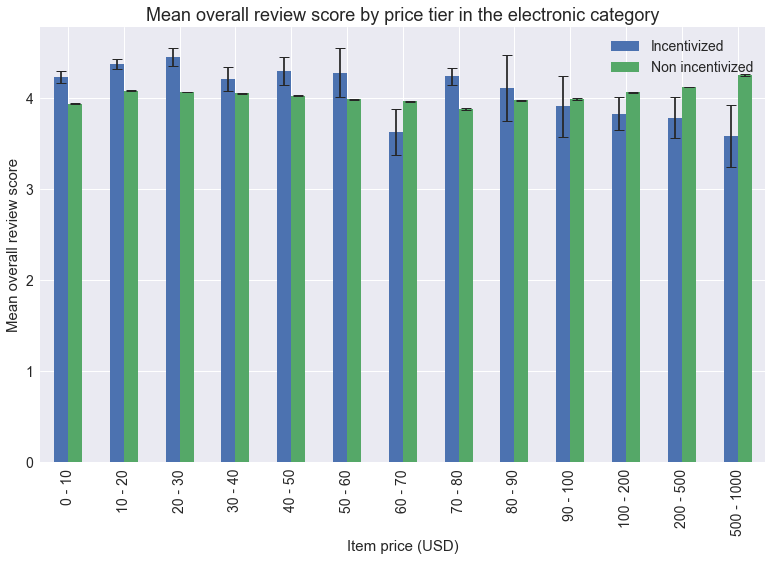

In [25]:
title = 'avg_rating_by_price_tier'

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_price_tier[title],
                        elec_non_incent_by_price_tier[title],
                        ax=ax)

ax.set_xticklabels(bin_labels)
ax.set_xlabel('Item price (USD)', LABEL_FONT)
ax.set_ylabel('Mean overall review score', LABEL_FONT)
plt.title('Mean overall review score by price tier in the electronic category', TITLE_FONT)

fig.savefig('elec_' + title + '.png', bbox_inches='tight')

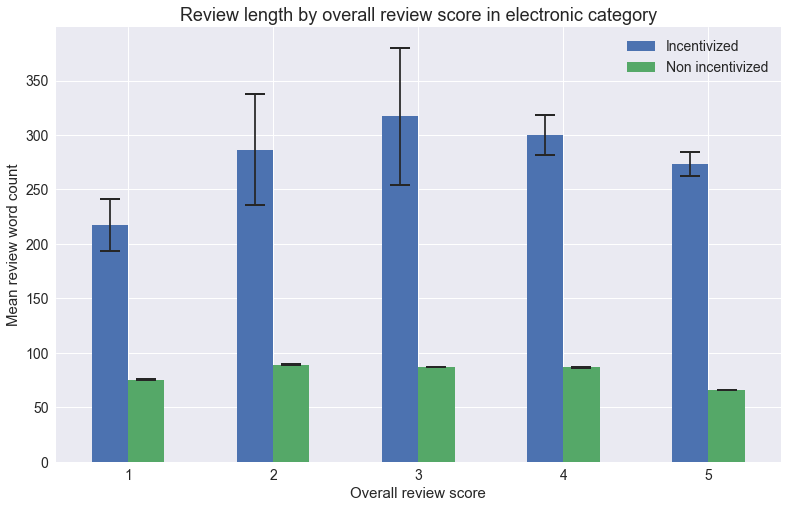

In [26]:
title = 'avg_length_by_overall'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_overall[title],
                        elec_non_incent_by_overall[title],
                        ax=ax)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Mean review word count', LABEL_FONT)
plt.title('Review length by overall review score in electronic category', TITLE_FONT)

fig.savefig('elec_' + title + '.png', bbox_inches='tight')

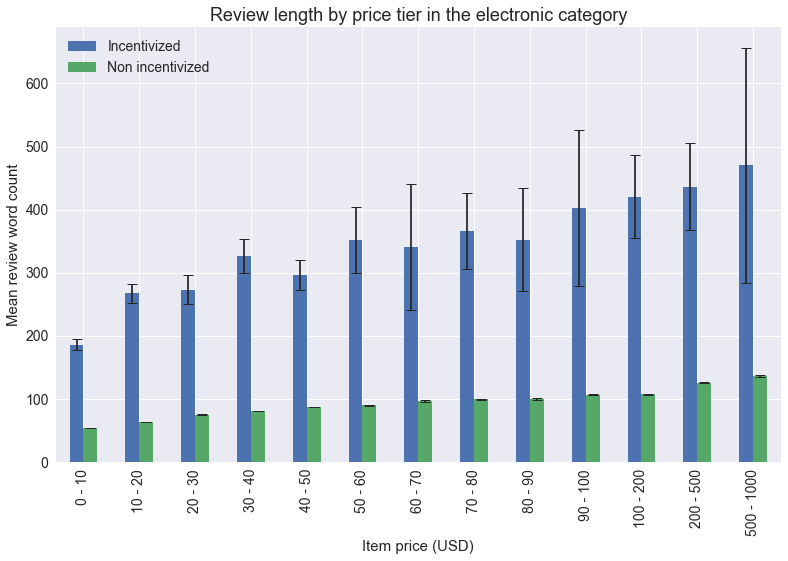

In [27]:
title = 'avg_length_by_price_tier'

mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_price_tier[title],
                        elec_non_incent_by_price_tier[title], ax=ax)

ax.set_xticklabels(bin_labels)
ax.set_xlabel('Item price (USD)', LABEL_FONT)
ax.set_ylabel('Mean review word count', LABEL_FONT)
plt.title('Review length by price tier in the electronic category', TITLE_FONT)

fig.savefig('elec_' + title + '.png', bbox_inches='tight')

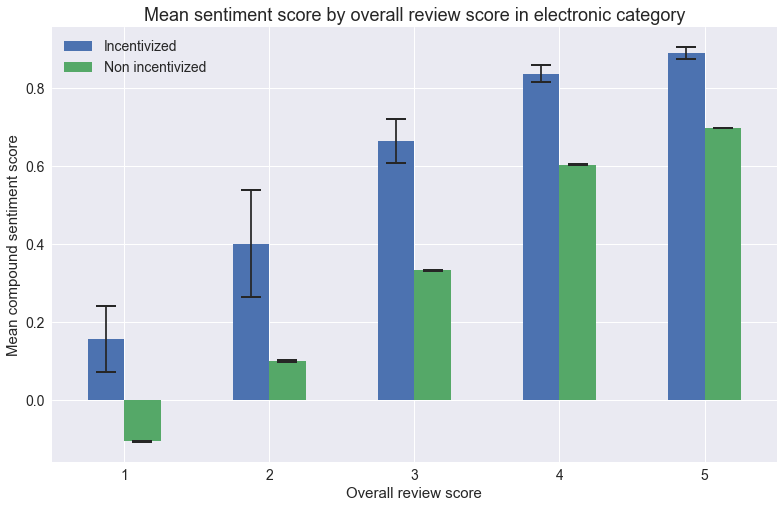

In [28]:
title = 'avg_compound_by_rating'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_overall[title],
                        elec_non_incent_by_overall[title],
                        ax=ax)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Mean compound sentiment score', LABEL_FONT)
plt.title('Mean sentiment score by overall review score in electronic category', TITLE_FONT)

fig.savefig('elec_' + title + '.png', bbox_inches='tight')

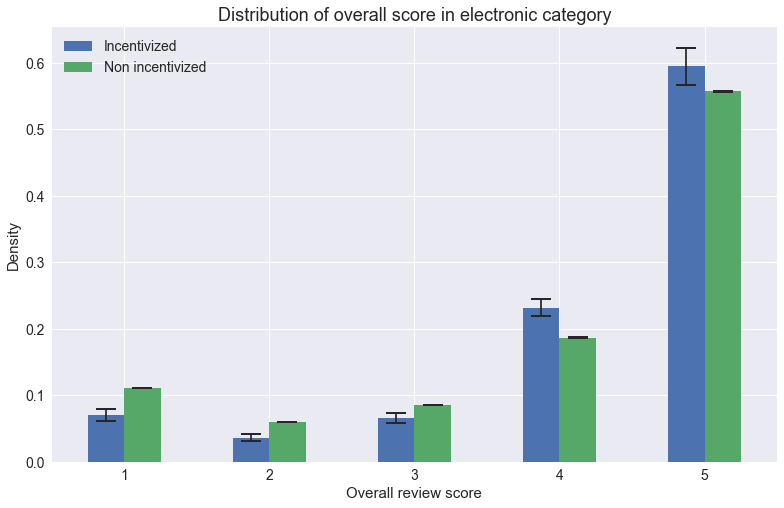

In [29]:
title = 'num_reviews_by_overall'

mpl.rcParams['errorbar.capsize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_with_conf_interval(elec_incent_by_overall[title],
                        elec_non_incent_by_overall[title],
                        ax=ax, normalize=True)

plt.xticks(rotation=0)
ax.set_xlabel('Overall review score', LABEL_FONT)
ax.set_ylabel('Density', LABEL_FONT)
plt.title('Distribution of overall score in electronic category', TITLE_FONT)

fig.savefig('elec_' + title + '.png', bbox_inches='tight')

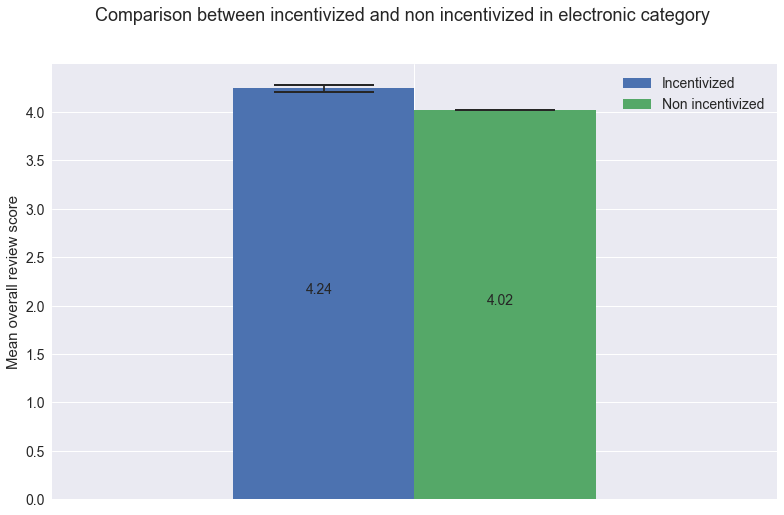

In [30]:
title = 'avg_rating'
data_incent = [group['_c0'] for sample in elec_incent3[title] for group in sample]
data_non_incent = [group['_c0'] for sample in elec_non_incent3[title] for group in sample]

mpl.rcParams['errorbar.capsize'] = 50
mpl.rcParams['lines.markeredgewidth'] = 2

fig, ax = plt.subplots(1,1,figsize=FIGSIZE)
plot_with_conf_interval({title: data_incent}, {title: data_non_incent}, ax=ax)

incent_mean, non_incent_mean = np.mean(data_incent), np.mean(data_non_incent)
ax.text(x=-0.15, y=incent_mean/2, s=str(np.round(incent_mean,2)), fontsize=14)
ax.text(x= 0.1, y=non_incent_mean/2, s=str(np.round(non_incent_mean,2)), fontsize=14)

ax.set_xticklabels('')

ax.set_ylabel('Mean overall review score', LABEL_FONT)
plt.suptitle('Comparison between incentivized and non incentivized in electronic category', **TITLE_FONT)

fig.savefig('elec_comp_incent.png', bbox_inches='tight')